In [1]:
#Import libraries
import os
import pydicom
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib as plt

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import own utilities
import net3d_model as model_3d
import preproc
import utils

In [3]:
# Load data and masks as dicom files
data_dir = '../../../data'                   #Please change the path accordingly before make any changes
normalnames = data_dir + '/normal_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

image_name_list, mask_name_list = utils.filter_image(normalnames, img_dir, msk_dir)
  
image_list = [pydicom.read_file(os.path.join(img_dir, filename)) for filename in image_name_list ]
msk_list = [pydicom.read_file(os.path.join(msk_dir, filename)) for filename in mask_name_list ]

# Normalizing images
image_list, msk_list = preproc.normalize(image_list, msk_list)

In [4]:
#Make loaded files to patches (both images and masks)

x_list = []
y_list = []
n_slices = 16   #Currently set it to 32 - TBD
for i in range(len(image_list)):
    try:
        n, x_data, y_data = preproc.to3dpatches(image_list[i], msk_list[i], n_slices)
    except:
        print("Warning: Dismissing one stack")
    else:
        for i in range(n):
            x_list.append(x_data[i])
            y_list.append(y_data[i])
    
x_list = np.stack(tuple([x for x in x_list]))[...,np.newaxis]
y_list = np.stack(tuple([y for y in y_list ]))[...,np.newaxis]
print(x_list.shape, y_list.shape)

Very likely to contain zero information in the labelled data
Very likely to contain zero information in the labelled data
(75, 16, 256, 256, 1) (75, 16, 256, 256, 1)


In [5]:
#Only train a little to save time when testing
x_list = x_list[0:10]
y_list = y_list[0:10]

In [6]:
model, prediction = model_3d.conv_net(activation_type = "tanh", n_slices = n_slices, depth = 3)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 16, 256, 256, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 256, 256, 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 256, 256, 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 256, 256, 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv3d_2 (

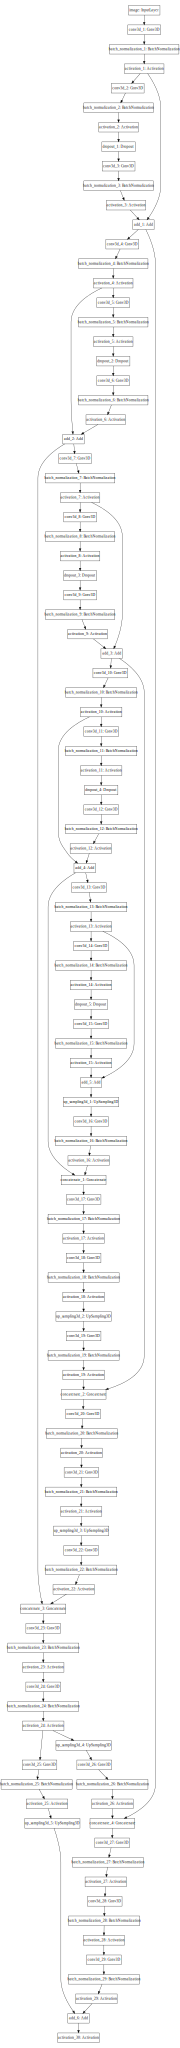

In [8]:
# This visualization might not work depending on how graphviz is installed, but it gives a simple overview of the structure.
#To do: output this image to file or in pop up window
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
model.compile(loss=model_3d.dice_coef_loss, optimizer='adam', metrics=['acc'])

In [10]:
#train_seq = image_mask_sequence('data/train', batch_size=10, size=256)
batch_size = 2
test_porpotion = (len(x_list)%batch_size + batch_size)/len(x_list)  #Just for convienient
#test_porpotion = 0.2
#a small number of prediction images
x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, test_size = test_porpotion, random_state=43)

In [11]:
#Will take a long time
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = batch_size,
                    epochs=3, verbose=1, shuffle=True)

Train on 8 samples, validate on 2 samples
Epoch 1/3
8/8 [==============================] - 367s 46s/step - loss: 0.9923 - acc: 0.3619 - val_loss: 0.9960 - val_acc: 0.2049
Epoch 2/3
8/8 [==============================] - 358s 45s/step - loss: 0.9907 - acc: 0.7043 - val_loss: 0.9960 - val_acc: 0.1930
Epoch 3/3
8/8 [==============================] - 370s 46s/step - loss: 0.9906 - acc: 0.8499 - val_loss: 0.9962 - val_acc: 0.0493


In [12]:
import matplotlib.pyplot as plt
plt.title('Training Progression')
plt.plot(history.epoch, history.history['loss'], label='loss')
#plt.plot(history.epoch, history.history[model_3d.dice_coef], label="dice coef")  #TBD
plt.xlabel('epoch')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [13]:
predictions = model.predict(x_list[0].reshape(1,16,256,256,1), steps=1)

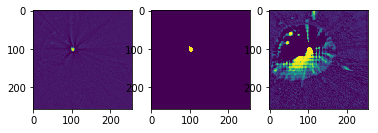

In [14]:
#Show original, mask, prediction
show = plt.figure()
show.add_subplot(1,3,1)
#plt.imshow(x_list[0][66])
plt.imshow(x_list[0][15].reshape(256,256))

show.add_subplot(1,3,2)
plt.imshow(y_list[0][15].reshape(256,256))
show.add_subplot(1,3,3)
plt.imshow(predictions[0][15].reshape(256,256))